This notebook contains SOTIP's spatial heterogeneity quantification module using a Visium Zebrafish dataset. For the steps, please refer to the table of contents automatically generated by jupyterlab on the left side bar.

author: Zhiyuan Yuan


# imports

In [1]:
from sotip import *

# data loading and processing steps

## load data

In [2]:
data_path = '../data'

data_file = 'sample_B.h5ad'
adata = ad.read_h5ad(f'{data_path}/{data_file}')


In [3]:
adata.obsm['spatial'] = adata.obsm['spatial_real']

## process data with scanpy

In [4]:
sc.pp.recipe_seurat(adata)

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

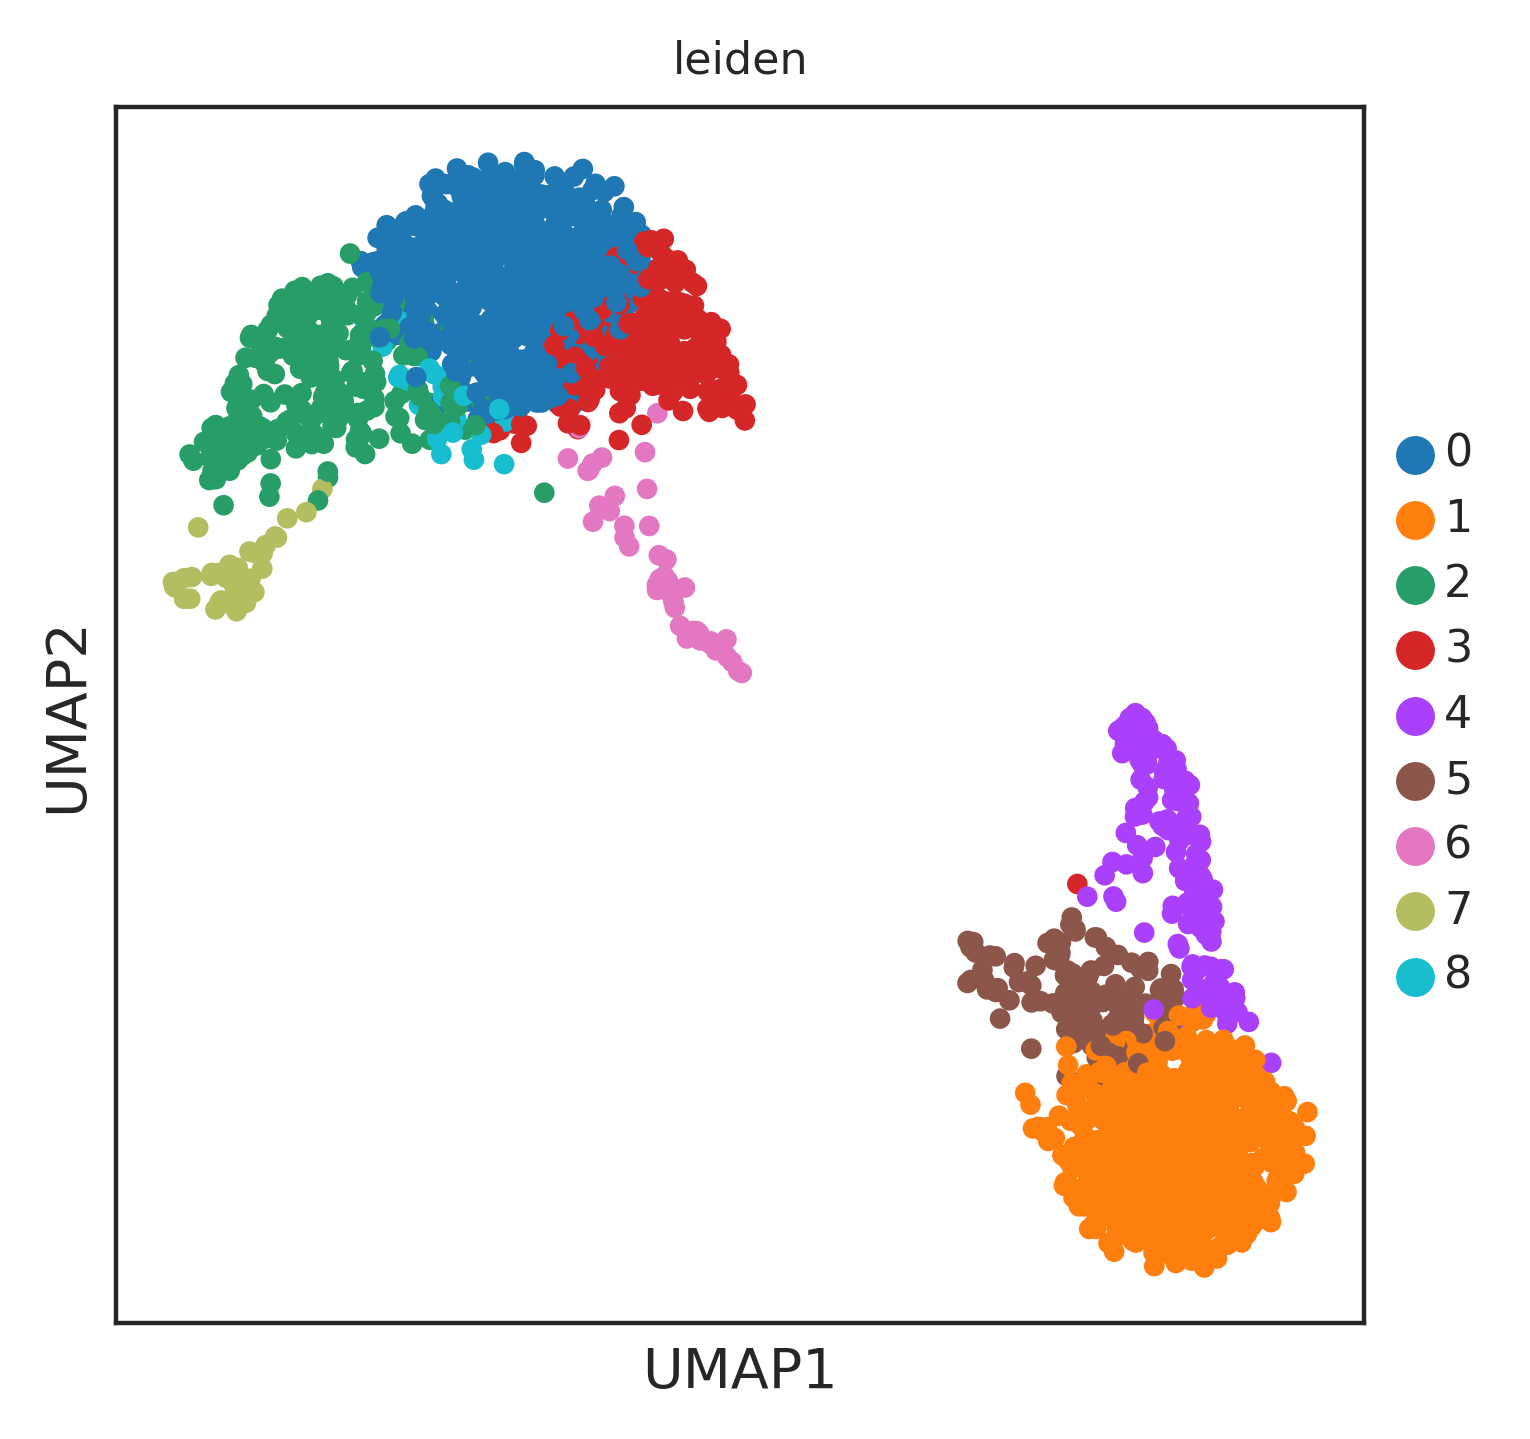

In [6]:
sc.pl.umap(adata,color=['leiden'])

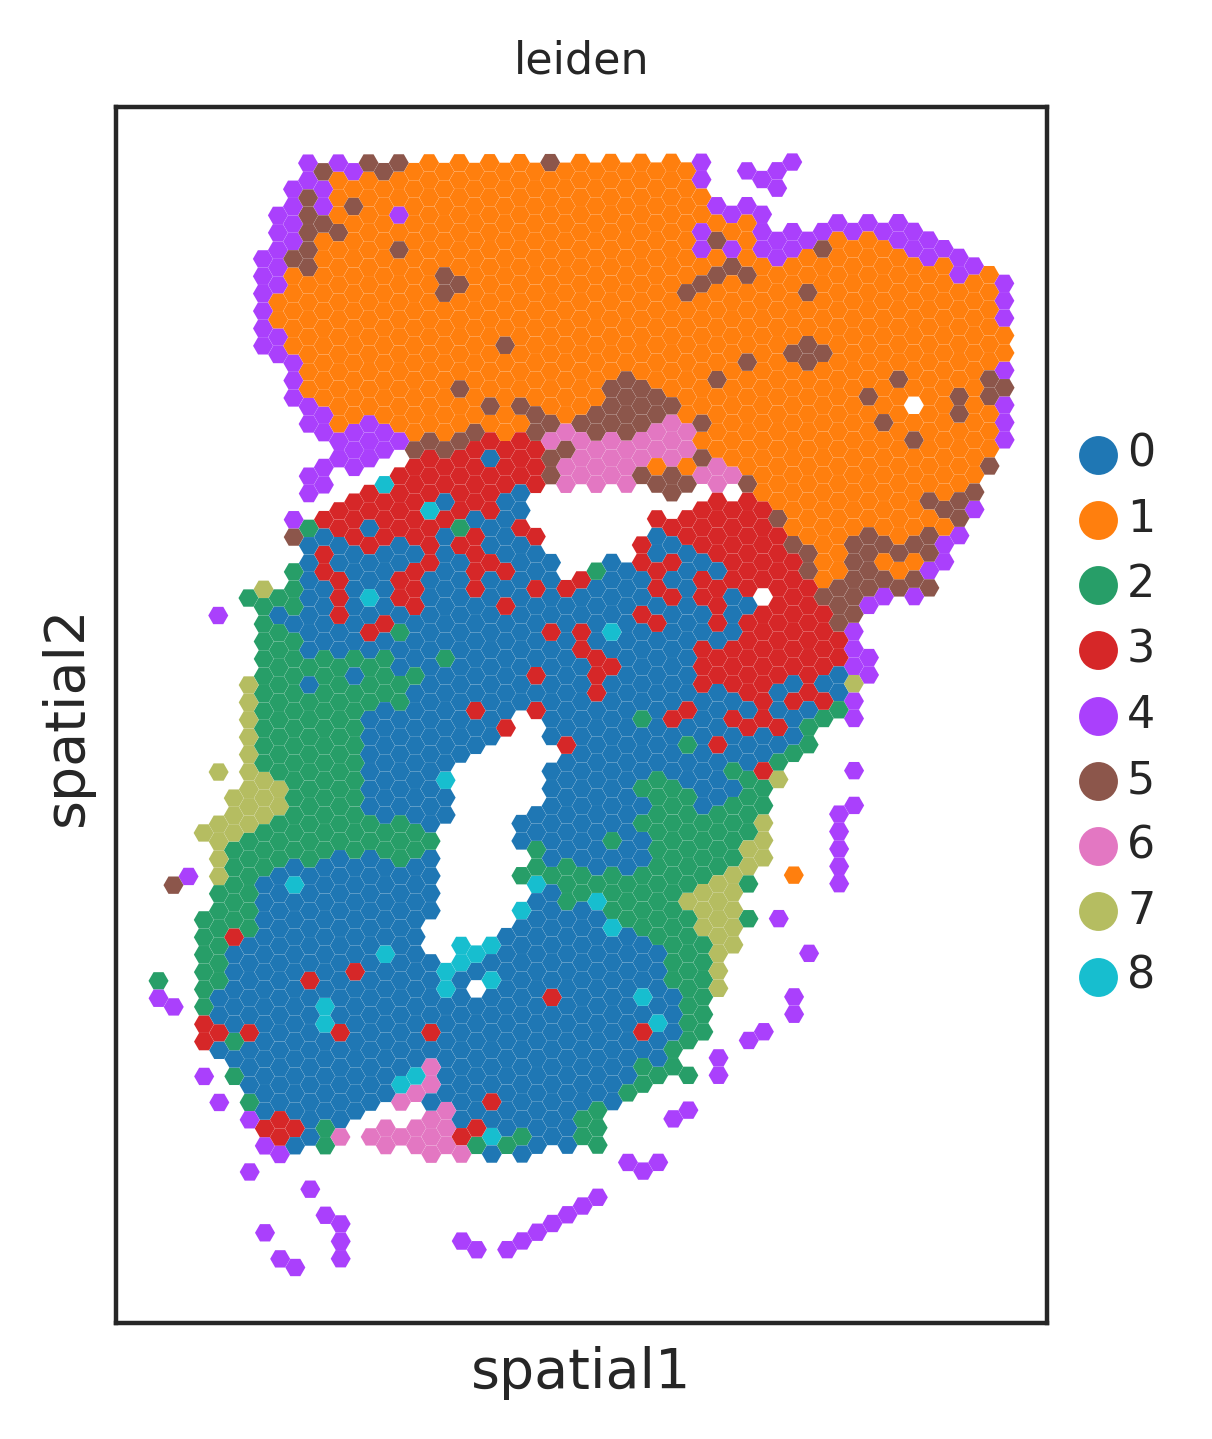

In [7]:
sc.pl.embedding(adata,basis='spatial',color=['leiden'],show=False,size=13,marker='H')
plt.gca().set_aspect('equal', adjustable='box') 


# SOTIP steps

## step 1: each ME is associated with its center cell

In [8]:
knn = 10
spatial_var='spatial'
cls_key='leiden'
# ME_var_names_np_unique = np.unique(adata.obs[cls_key]) 
ME_var_names_np_unique = np.array(adata.obs[cls_key].cat.categories)

# MED_multi(adata,use_cls=cls_key,nn=knn,copy=False,spatial_var=spatial_var,batch_obs='batch')
MED(adata,use_cls=cls_key,nn=knn,copy=False,ME_var_names_np_unique=ME_var_names_np_unique,spatial_var=spatial_var) 
  


knn search time cost 0.0053136348724365234 s
0 MEs,time cost 1.6689300537109375e-06 s, 2176 MEs, 3.631591796875e-06s left
1000 MEs,time cost 0.14779186248779297 s, 1176 MEs, 0.17380323028564454s left
2000 MEs,time cost 0.13991761207580566 s, 176 MEs, 0.024625499725341796s left


array([[ 0.,  7.,  0., ...,  0.,  0.,  0.],
       [ 0.,  8.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.],
       ...,
       [10.,  0.,  0., ...,  0.,  0.,  0.],
       [ 8.,  0.,  2., ...,  0.,  0.,  0.],
       [ 7.,  0.,  0., ...,  0.,  0.,  0.]])

## step 2: Connectivity guided minimum graph distance (CGMGD)

### step 2.1 topological structure is computed with paga

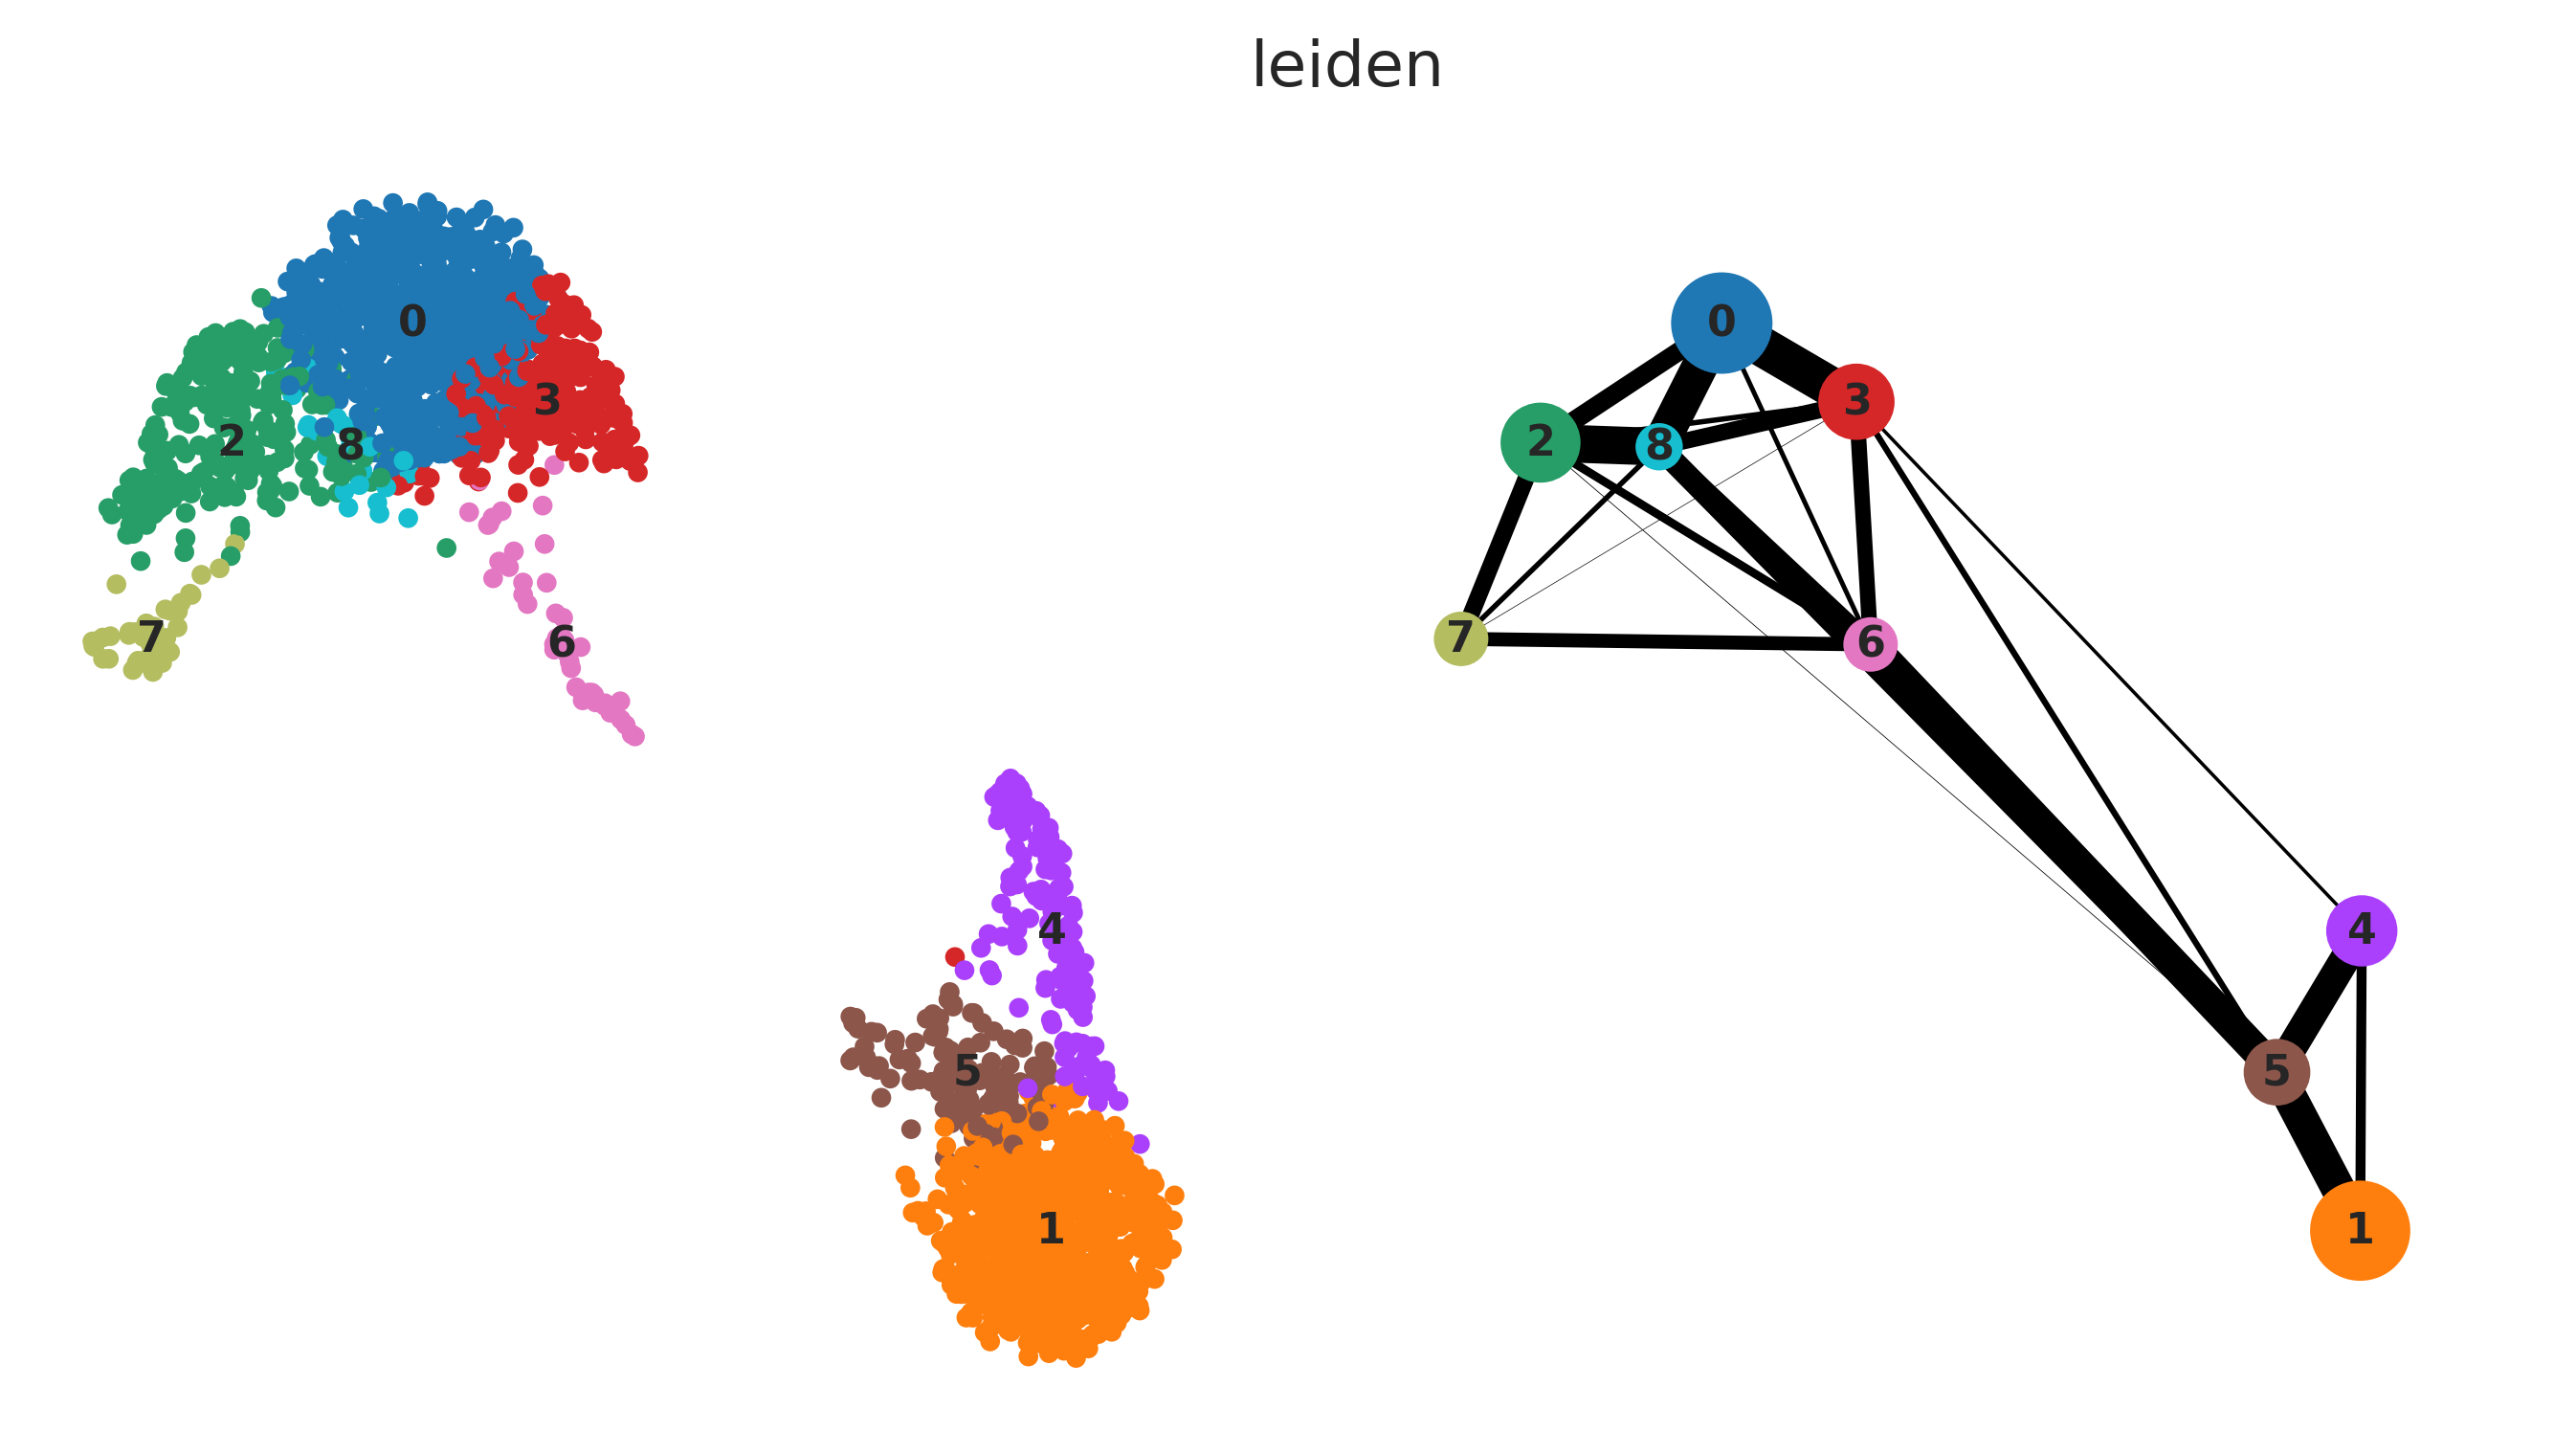

In [9]:
cls_key = 'leiden'
sc.tl.paga(adata,groups=cls_key)
sc.pl.paga_compare(adata,basis='X_umap')

### step 2.2 the connectivities between cell clusters is used to guide the graph distance computation

In [10]:
gd_method = 'paga_guided_umap'
gd = get_ground_distance(adata,method=gd_method,cls_key=cls_key,embed_key=None)  


### step 2.3 compute SHN

In [11]:
heter_key = 'ME_heter_{0}_{1}'.format(cls_key,gd_method)

cal_ME_heterogeneity(adata,copy=False,key_added=heter_key) 

### step 2.4 plot

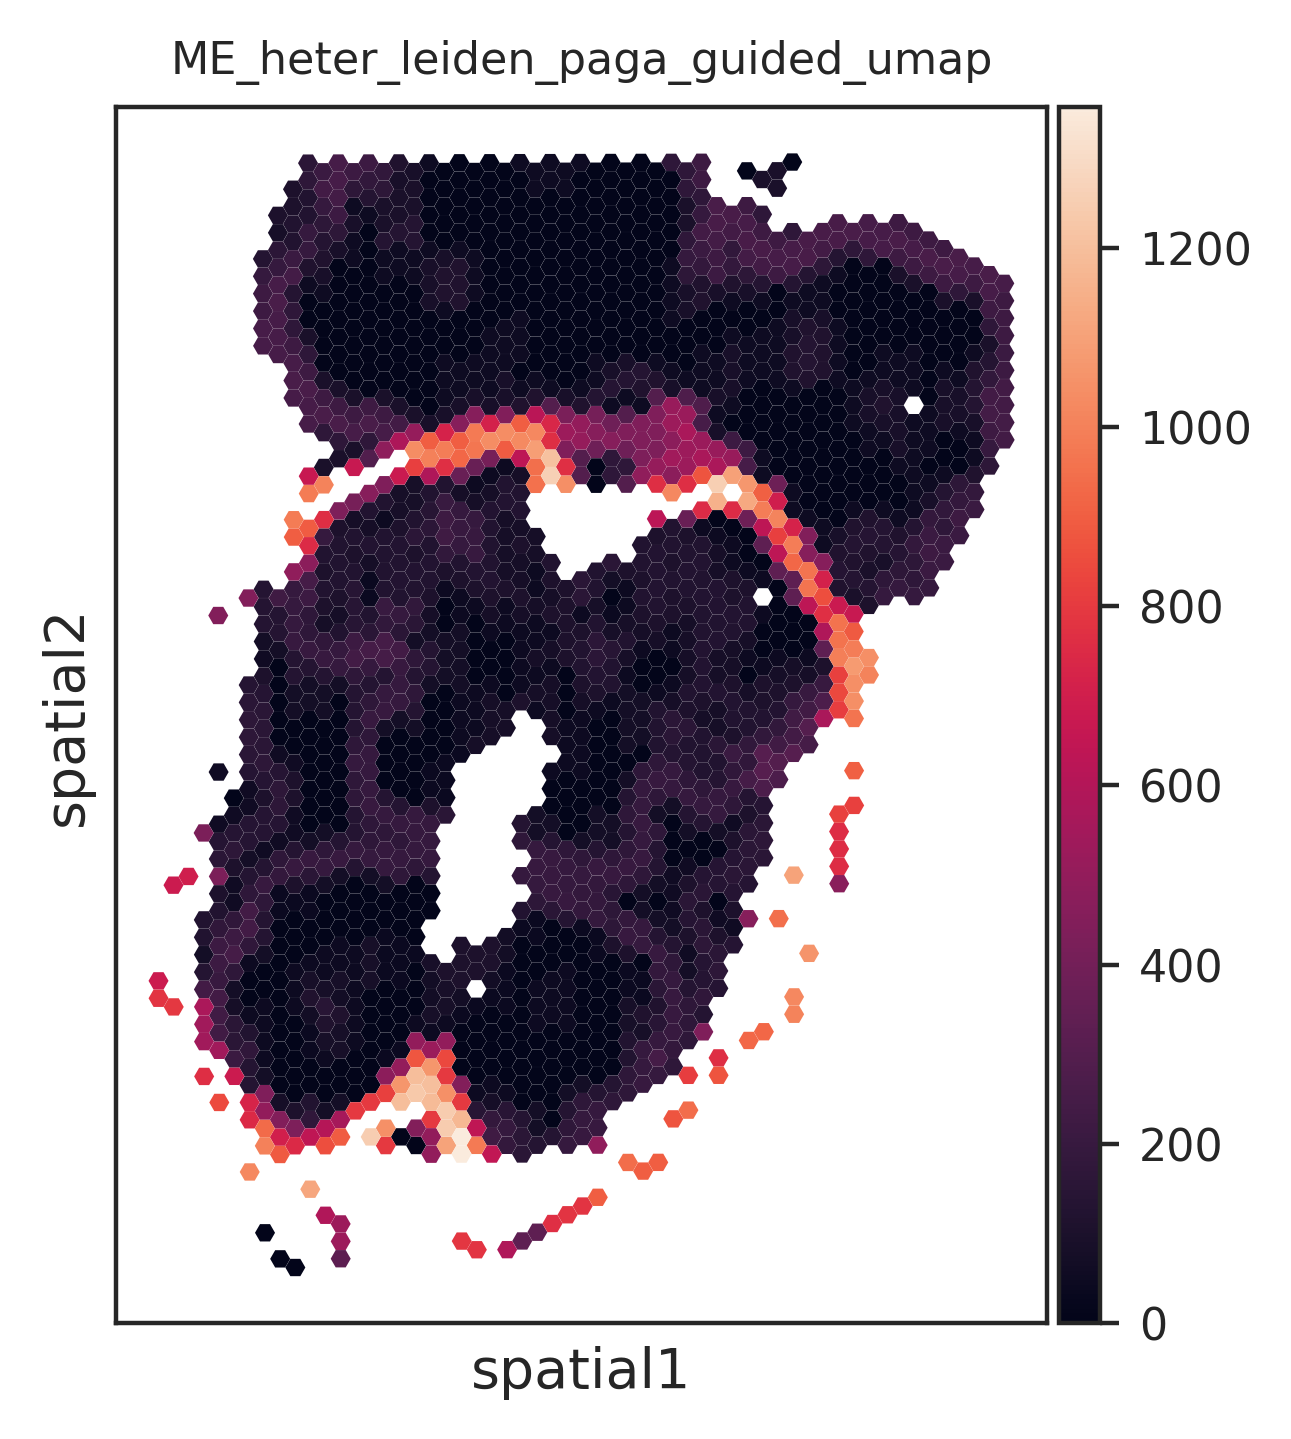

In [12]:
sc.pl.embedding(adata,basis='spatial',color=[heter_key],show=False,size=13,marker='H')
plt.gca().set_aspect('equal', adjustable='box') 
